<a href="https://colab.research.google.com/github/yumehara/atmacup11/blob/main/notebooks/atmacup11_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from typing import List, Optional
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
def get_path(filename):
    return os.path.join('/content/drive/MyDrive/atmacup11', filename)

In [23]:
csv_files = glob.glob(get_path('inputs/*.csv'))
csv_files

['/content/drive/MyDrive/atmacup11/inputs/atmaCup#11_sample_submission.csv',
 '/content/drive/MyDrive/atmacup11/inputs/materials.csv',
 '/content/drive/MyDrive/atmacup11/inputs/techniques.csv',
 '/content/drive/MyDrive/atmacup11/inputs/test.csv',
 '/content/drive/MyDrive/atmacup11/inputs/train.csv']

In [24]:
jpg_files = glob.glob(get_path('inputs/photos/*.jpg'))
print(f'jpg ファイルは {len(jpg_files)} 個')
jpg_files[:5]

jpg ファイルは 9856 個


['/content/drive/MyDrive/atmacup11/inputs/photos/13e702f0d39263960f8b.jpg',
 '/content/drive/MyDrive/atmacup11/inputs/photos/6c0e4c2521907f496a32.jpg',
 '/content/drive/MyDrive/atmacup11/inputs/photos/28cf198b0fd8a19ddfae.jpg',
 '/content/drive/MyDrive/atmacup11/inputs/photos/68f8e734e0dd842eda50.jpg',
 '/content/drive/MyDrive/atmacup11/inputs/photos/07473523bf0ab411bb25.jpg']

### EDA

In [15]:
def get_size_channel(jpg_file: str) -> List[int]:
    '''画像の高さ、幅、チャネル数を取得する。
    '''
    img = plt.imread(jpg_file)
    # グレースケールではないこと
    assert(img.ndim == 3)
    return [
        img.shape[0],  # 高さ
        img.shape[1],  # 幅
        img.shape[2]  # チャネル数
    ]

In [16]:
size_channel_info = []
for jpg_file in tqdm(jpg_files):
    size_ch = get_size_channel(jpg_file)
    size_channel_info.append(size_ch)

100%|██████████| 9856/9856 [00:21<00:00, 450.87it/s]


In [17]:
# データフレーム化して集計する
df_size_channel = pd.DataFrame(data=size_channel_info, columns=['height', 'width', 'channels'])
df_size_channel['filename'] = jpg_files
df_size_channel.describe()

,height,width,channels
count,9856.000000,9856.000000,9856.0
mean,191.405438,194.124290,3.0
std,37.690367,33.473324,0.0
min,35.000000,72.000000,3.0
25%,158.000000,165.000000,3.0
50%,224.000000,213.000000,3.0
75%,224.000000,224.000000,3.0
max,224.000000,224.000000,3.0


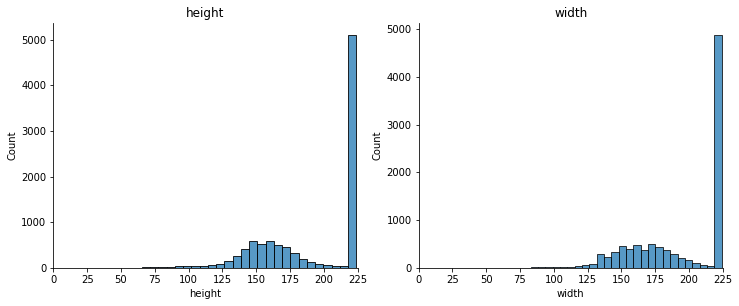

In [18]:
figure = plt.figure(figsize=(12, 4.5))
for i, column in enumerate(['height', 'width']):
    ax = plt.subplot(1, 2, i + 1)
    ax.set_title(column)
    ax.set_xlim(0, 225)
    sns.histplot(data=df_size_channel, x=column)
    sns.despine()

### train

In [25]:
train = pd.read_csv(get_path('inputs/train.csv'))
train.head()

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   object_id      3937 non-null   object
 1   sorting_date   3937 non-null   int64 
 2   art_series_id  3937 non-null   object
 3   target         3937 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 123.2+ KB


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,475,1563.934737,36.919201,1440,1542.0,1574.0,1599.0,1600
1,896,1656.529018,31.699871,1601,1628.0,1655.0,1683.0,1700
2,1511,1760.007942,27.400390,1701,1741.0,1770.0,1782.0,1800
3,1055,1845.600948,29.248996,1801,1823.0,1841.0,1870.0,1991


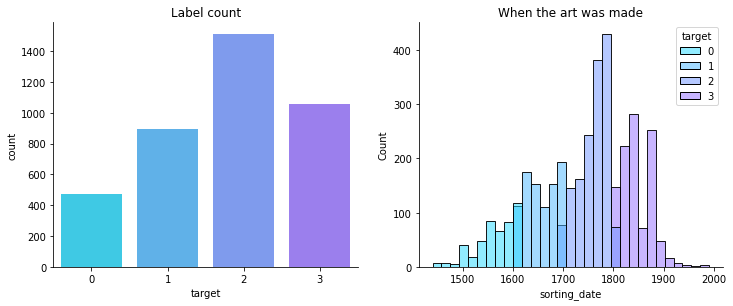

In [29]:
fig = plt.figure(figsize=(12, 4.5))
plt.subplot(1, 2, 1)
ax = sns.countplot(data=train, x='target', palette=sns.color_palette('cool'))
ax.set_title('Label count')
sns.despine()
plt.subplot(1, 2, 2)
ax = sns.histplot(data=train, x='sorting_date', hue='target',
                  palette=sns.color_palette('cool')[:train['target'].nunique()])
ax.set_title('When the art was made')
sns.despine()

# Statistics
sorting_date_stat = train.groupby('target')['sorting_date'].describe().sort_index()
for column in ('count', 'min', 'max'):
    sorting_date_stat[column] = sorting_date_stat[column].astype('int')
sorting_date_stat

In [30]:
art_series = train.groupby('art_series_id')['sorting_date'].describe()
for column in ('count', 'min', 'max'):
    art_series[column] = art_series[column].astype('int')    
art_series['range'] = art_series['max'] - art_series['min']  # シリーズの製作期間（開始～終了の年数）

In [37]:
art_series[art_series['count']>2].sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max,range
art_series_id,,,,,,,,,
607c22f5e66e8d50a298,9,1633.000000,0.000000,1633,1633.0,1633.0,1633.00,1633,0
6fb734ceff36fe2184b5,7,1851.571429,4.503967,1848,1848.0,1848.0,1856.00,1857,9
78db88c5ca6d7f6f4ac6,6,1799.833333,21.226556,1775,1780.0,1805.5,1818.25,1819,44
9f6b6e88a57613d73742,4,1675.250000,60.500000,1645,1645.0,1645.0,1675.25,1766,121
f8b88aff7f66a106ba3f,4,1819.000000,0.000000,1819,1819.0,1819.0,1819.00,1819,0
600db76c79a01bc40eb1,4,1662.500000,75.000000,1550,1662.5,1700.0,1700.00,1700,150
6aa2a6ecc643ec58f8bc,3,1874.000000,0.000000,1874,1874.0,1874.0,1874.00,1874,0
64f243afd58d024cd253,3,1874.000000,0.000000,1874,1874.0,1874.0,1874.00,1874,0
767092249ef8adf7cfc9,3,1809.333333,29.771351,1775,1800.0,1825.0,1826.50,1828,53


In [34]:
art_series['count'].value_counts()

1    3666
2      99
3      13
4       3
9       1
7       1
6       1
Name: count, dtype: int64

In [43]:
def draw_image_file(object_id):
    impath = get_path(f'inputs/photos/{object_id}.jpg')
    image = plt.imread(impath)
    plt.imshow(image)
    plt.show()

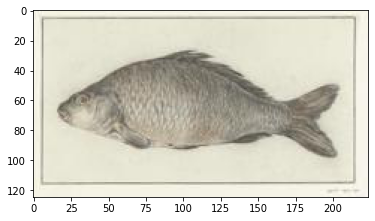

sorting_date 1775


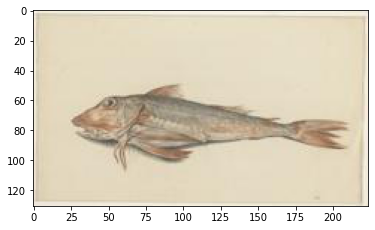

sorting_date 1816


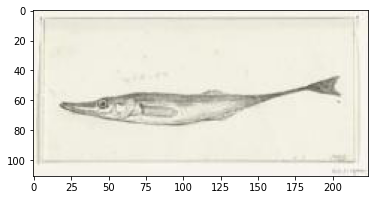

sorting_date 1819


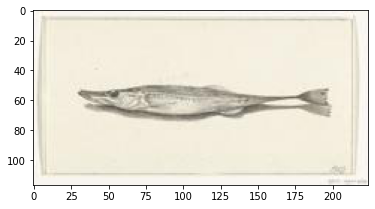

sorting_date 1819


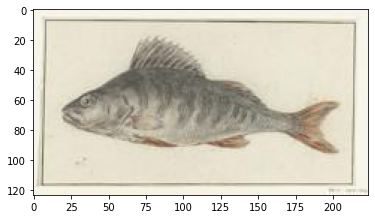

sorting_date 1775


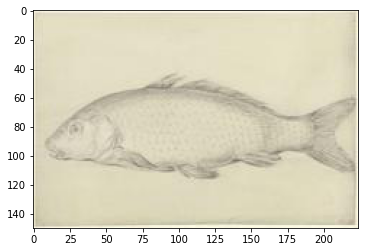

sorting_date 1795


In [62]:
art_series_id = '78db88c5ca6d7f6f4ac6'
for object_id in train[train['art_series_id']==art_series_id]['object_id']:
    draw_image_file(object_id)
    print('sorting_date', train[train['object_id'] == object_id]['sorting_date'].iloc[0])

### techniques

In [63]:
techniques = pd.read_csv(get_path('inputs/techniques.csv'))
techniques.head()

,name,object_id
0,pen,002bff09b09998d0be65
1,brush,00309fb1ef05416f9c1f
2,counterproof,004890880e8e7431147b
3,brush,007f5e3620b458d77212
4,brush,00bf812ffe8a62d45661


In [65]:
techniques['name'].value_counts()

brush                   2179
pen                     1569
counterproof              17
chalk                      3
engraving                  2
snipping                   2
pencil                     2
scoring                    1
letterpress printing       1
sewing                     1
Name: name, dtype: int64

In [64]:
materials = pd.read_csv(get_path('inputs/materials.csv'))
materials.head()

,name,object_id
0,ink,002bff09b09998d0be65
1,paper,002bff09b09998d0be65
2,pencil,002bff09b09998d0be65
3,watercolor (paint),00309fb1ef05416f9c1f
4,paper,00309fb1ef05416f9c1f


In [66]:
materials['name'].value_counts()

paper                          3746
ink                            1589
chalk                          1509
pencil                         1135
watercolor (paint)              543
deck paint                      130
graphite (mineral)              122
prepared paper                   91
parchment (animal material)      61
paint (coating)                  43
gouache (paint)                  38
oil paint (paint)                33
cardboard                        18
tracing paper                     8
linen (material)                  3
leather                           2
India ink (ink)                   2
palm leaf (material)              1
wood (plant material)             1
varnish                           1
velvet (fabric weave)             1
metal                             1
zinc                              1
gold leaf                         1
bristol board                     1
Name: name, dtype: int64

### test

In [68]:
test = pd.read_csv(get_path('inputs/test.csv'))
print(test.shape)
test.head()

(5919, 1)


,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3


### sample

In [69]:
sample = pd.read_csv(get_path('inputs/atmaCup#11_sample_submission.csv'))
print(sample.shape)
sample.head()

(5919, 1)


,target
0,3
1,1
2,3
3,3
4,0
